# Jérôme III – YOLOv8 Implementation of Grad-CAM


**Author:** Éloïse Delerue

**Laboratory:** Université Paris Sciences & Lettres

**Contact:** eloise.delerue@psl.eu

**Date:** December 26th, 2025

## 0. Read Me

### 0.1 Overview

**Jérôme III** is a notebook that focuses on Explainable AI (XAI). Using **Grad-CAM** (Gradient-weighted Class Activation Mapping), we visualize the internal "reasoning" of the YOLOv8 model. The goal is to identify which specific **visual features** trigger a detection.

### 0.2. Methodology

We utilize the `yolov8-gradcam` framework to extract gradients from the model's architecture.

- **Target Layer:** We specifically monitor the SPPF (Spatial Pyramid Pooling - Fast) layer.
- **Visualization:** The process generates a heatmap that is superimposed on the original image, highlighting the regions of high neural activation.

**Why SPPF?**

The SPPF is the final layer of the YOLOv8 "backbone". It aggregates features at various scales to consolidate the model's understanding of the image before passing it to the detection heads.

Unlike earlier layers that detect simple edges or textures, the SPPF layer captures complex shapes and semantic relationships (e.g., "this group of pixels forms a human silhouette in a 17th-century style").

Because it is the "bottleneck" of the backbone, it provides the most meaningful gradients for understanding the model's global decision-making process.

**Critical Interpretation & Limitations**

While Grad-CAM is a powerful tool for Explainable AI (XAI), its results must be interpreted with caution:

1.   The heatmap only represents the model's state at one specific point (the SPPF layer). It does not account for the logic happening in the earlier "Neck" or the final "Head" layers.
2.   A high activation area (red zone) indicates that those pixels were mathematically important for the final prediction. It does not mean the model "sees" or "reasons" like a human art historian.
3.   The heatmap is generated at a lower resolution and then upscaled. Fine details may be blurred, meaning the visualization is an approximation, not a pixel-perfect map of "truth."

**[NOTE]** Several times, we use the `%%writefile` command to generate standalone scripts.

`%%writefile` is not standard Python code. It is a specific to Jupyter environments like Google Colab. It captures the entire content of the cell and saves it as a physical file on the environment's disk. Thus, the code inside a `%%writefile` cell is not executed when you run the cell; it is only written to the disk.

These files are run with the system command `!python main.py` in **section 5**.

### 0.3. Key Features

- **External Image Testing:** Fetch images directly from the web for immediate analysis.

- **Side-by-Side Comparison:** Displays the raw input next to the Grad-CAM output for better interpretability.

- **Integrated Bounding Boxes:** Visualizes both the heatmap and the final detection boxes simultaneously.

### 0.4. References

The development of this XAI (Explainable AI) module was made possible by the integration of several open-source libraries and academic tutorials.

**Core Model & Architecture:**
- [YOLOv8 Documentation](https://github.com/ultralytics/ultralytics/blob/main/docs/en/models/yolov8.md): Official Ultralytics repository for model implementation.
- [YOLO Architecture Overview](https://github.com/ultralytics/ultralytics/blob/main/docs/en/yolov5/tutorials/architecture_description.md): Detailed description of the YOLO series structure.

**Grad-CAM Implementation for YOLO:**
- [YOLOv8-GradCAM Library](https://github.com/eirikmn/ultralytics-yolov8_gradcam?tab=readme-ov-file): The primary framework used for gradient extraction in this notebook.
- [YOLOv5-GradCAM](https://github.com/pooya-mohammadi/yolov5-gradcam): Foundational logic for porting Grad-CAM to the YOLO series.
- [Ultralytics Integration Guide](https://yolov8.org/how-to-integrate-grad-cam-to-yolov8/): Best practices for integrating visual explanations with YOLOv8.

**Theoretical & General Grad-CAM Resources:**
- [PyTorch Grad-CAM Tutorials](https://github.com/jacobgil/pytorch-grad-cam/blob/master/tutorials/EigenCAM%20for%20YOLO5.ipynb): Comprehensive guides on using EigenCAM and Grad-CAM for Vision Transformers and YOLOv5.
- [Keras Grad-CAM Implementation](https://keras.io/examples/vision/grad_cam/#setup): Official Keras examples for baseline class activation mapping.
- [Technical Guides](https://www.codetrade.io/blog/grad-cam-a-complete-guide-with-example/): In-depth articles on visualizing explanations from deep networks using PyTorch.



```
def get_res_img(bbox, mask, res_img):
    """
    Applique un masque de luminosité strict.
    Tout ce qui n'est pas activé par le masque devient noir.
    """
    # 1. Préparation du masque (H, W, 1) pour correspondre aux 3 canaux (BGR)
    if len(mask.shape) == 2:
        mask = mask[:, :, np.newaxis]

    # 2. Normalisation stricte entre 0 et 1
    mask = np.float32(mask)
    if mask.max() > 0:
        mask = mask / mask.max()

    # 3. Application directe
    # Les zones où mask == 0 deviendront (R,G,B) * 0 = (0,0,0) -> Noir
    res_img_float = np.float32(res_img)
    cam = res_img_float * mask

    return np.uint8(cam), mask
```



## 1. Environment Setup & Dependencies

In [3]:
# Installing Required Librarie
!pip install -q ultralytics grad-cam opencv-python

In [4]:
# File and Directory Management
import os
import glob
import shutil
import zipfile
from io import BytesIO

# Networking and Web Requests
import requests

# Numerical Computation and Deep Learning Frameworks
import torch
import numpy as np

# Image Processing and Computer Vision
import cv2
from PIL import Image

# Data Visualization
import matplotlib.pyplot as plt

# Google Colab Specific Utilities
from google.colab import files

In [5]:
# Models Directory Creation
os.makedirs('models', exist_ok=True)

## 2. Modules Creation

### 2.1. Utility Module

This cell creates a local Python script named `deep_utils.py`. This module acts as a toolbox for image processing and bounding box manipulation, providing essential helper functions to keep the main notebook clean and organized.

In [6]:
%%writefile deep_utils.py

# Libraries Import
import cv2
import numpy as np
import os

# Helper Function
def split_extension(path, suffix=''):
    """
    Inserts a suffix between the filename and its extension.

    Args:
        path: Full path or filename (e.g., 'myfile.txt').
        suffix: String to insert before the extension (default: empty string).

    Returns:
        Modified path or filename with the suffix inserted before the extension.
    """
    root, ext = os.path.splitext(path)
    return f"{root}{suffix}{ext}"

# Box Utility Class
class Box:
    class BoxSource:
        Torch = 'torch'
        Numpy = 'numpy'

    @staticmethod
    def box2box(box, in_source, to_source, return_int=True):
        """
        Converts a bounding box from one format/source to another.
        Assumes input is already in x1, y1, x2, y2 format (e.g., YOLOv8 post-NMS).

        Args:
            box: Bounding box coordinates.
            in_source: Source format of the input box (e.g., 'torch', 'numpy').
            to_source: Target format for the output box.
            return_int: If True, returns coordinates as integers (default: True).

        Returns:
            Converted bounding box as a list of coordinates.
        """
        b = [float(x) for x in box]
        if return_int:
            b = [int(x) for x in b]
        return b

    @staticmethod
    def put_box(img, bbox):
        """
        Draws a bounding box on the given image.

        Args:
            img: Input image (numpy array).
            bbox: Bounding box coordinates as [x1, y1, x2, y2].

        Returns:
            Image with the bounding box drawn.
        """
        x1, y1, x2, y2 = bbox
        cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
        return img

    @staticmethod
    def put_text(img, text, pos):
        """
        Draws text on the given image at the specified position.

        Args:
            img: Input image (numpy array).
            text: Text to draw.
            pos: Position (x, y) where the text should be drawn.

        Returns:
            Image with the text drawn.
        """
        cv2.putText(img, text, pos, cv2.FONT_HERSHEY_SIMPLEX,
                    0.6, (0, 255, 0), 2)
        return img

    @staticmethod
    def fill_outer_box(heatmap, bbox):
        """
        Masks everything outside the given bounding box in the heatmap.

        Args:
            heatmap: Input heatmap (numpy array).
            bbox: Bounding box coordinates as [x1, y1, x2, y2].

        Returns:
            Heatmap with values outside the box set to zero.
        """
        mask = np.zeros_like(heatmap)
        x1, y1, x2, y2 = bbox
        mask[y1:y2, x1:x2] = heatmap[y1:y2, x1:x2]
        return mask

Writing deep_utils.py


### 2.2. Model Wrapper

This cell creates a local Python script named `yolov8_object_detector.py`. This module defines the `YOLOv8ObjectDetector` class, which serves as a specialized wrapper to bridge the standard YOLOv8 model with the Grad-CAM visualization requirements.

In [7]:
%%writefile yolov8_object_detector.py

# Libraries Import
import numpy as np
import torch
import torch.nn as nn
import cv2
import torchvision
from ultralytics import YOLO
from deep_utils import Box

# YOLOv8 Object Detector Class
class YOLOv8ObjectDetector(nn.Module):
    def __init__(self, model_path, device, img_size=(640, 640), confidence=0.4, iou_thresh=0.45):
        """
        Constructor; loads the YOLOv8 model into memory.

        Args:
            model_path: Path to the YOLOv8 model file.
            device: Device to run the model on (e.g., 'cuda' or 'cpu').
            img_size: Input image size (height, width).
            confidence: Confidence threshold for detections.
            iou_thresh: IoU threshold for NMS.
        """
        super(YOLOv8ObjectDetector, self).__init__()
        self.device = device
        self.img_size = img_size
        self.confidence = confidence
        self.iou_thresh = iou_thresh
        print(f"[INFO] Loading YOLOv8 model from {model_path}...")
        self.yolo_wrapper = YOLO(model_path)
        self.model = self.yolo_wrapper.model
        self.model.requires_grad_(True)
        self.model.to(device)
        self.model.eval()
        self.names = self.model.names

    def preprocessing(self, img):
        """
        Converts a pixel matrix into a tensor.

        Args:
            img: Input image (numpy array).

        Returns:
            Tensor ready for model input, and original image shape.
        """
        original_shape = img.shape[:2]
        img_resized = cv2.resize(img, self.img_size)
        img_input = img_resized.transpose((2, 0, 1))
        img_input = np.ascontiguousarray(img_input)
        img_input = torch.from_numpy(img_input).to(self.device)
        img_input = img_input.float() / 255.0
        if len(img_input.shape) == 3:
            img_input = img_input.unsqueeze(0)
        return img_input, original_shape

    def custom_nms(self, preds):
        """
        Custom Non-Maximum Suppression using torchvision.

        Args:
            preds: Raw model predictions.

        Returns:
            List of filtered detections after NMS.
        """
        preds = preds.transpose(1, 2)
        output_list = []
        for i, pred in enumerate(preds):
            boxes = pred[:, :4]
            scores = pred[:, 4:]
            class_conf, class_pred = torch.max(scores, 1, keepdim=False)
            conf_mask = class_conf > self.confidence
            boxes = boxes[conf_mask]
            class_conf = class_conf[conf_mask]
            class_pred = class_pred[conf_mask]
            if boxes.size(0) == 0:
                output_list.append([])
                continue
            box_xyxy = boxes.clone()
            box_xyxy[:, 0] = boxes[:, 0] - boxes[:, 2] / 2
            box_xyxy[:, 1] = boxes[:, 1] - boxes[:, 3] / 2
            box_xyxy[:, 2] = boxes[:, 0] + boxes[:, 2] / 2
            box_xyxy[:, 3] = boxes[:, 1] + boxes[:, 3] / 2
            keep_indices = torchvision.ops.nms(box_xyxy, class_conf, self.iou_thresh)
            final_boxes = box_xyxy[keep_indices]
            final_scores = class_conf[keep_indices]
            final_classes = class_pred[keep_indices]
            out = torch.cat((final_boxes, final_scores.unsqueeze(1), final_classes.unsqueeze(1).float()), 1)
            output_list.append(out)
        return output_list

    def forward(self, img, original_shape=None):
        """
        Forward pass; returns detection boxes and raw predictions with gradients.

        Args:
            img: Input image tensor.
            original_shape: Original image shape for rescaling.

        Returns:
            List of boxes, classes, names, and confidences; and raw predictions.
        """
        preds = self.model(img)
        if isinstance(preds, list) or isinstance(preds, tuple):
            preds = preds[0]
        nms_preds = self.custom_nms(preds)

        boxes_list, classes_list, names_list, confs_list = [], [], [], []

        for i, det in enumerate(nms_preds):
            img_boxes, img_classes, img_names, img_confs = [], [], [], []

            if len(det) > 0:
                if original_shape is not None:
                    h, w = original_shape
                    scale_h, scale_w = h / self.img_size[1], w / self.img_size[0]
                    det[:, 0] *= scale_w; det[:, 1] *= scale_h
                    det[:, 2] *= scale_w; det[:, 3] *= scale_h
                    det[:, :4] = det[:, :4].round()

                for *xyxy, conf, cls in det:
                    bbox = Box.box2box([c.detach() for c in xyxy], Box.BoxSource.Torch, Box.BoxSource.Numpy, True)
                    img_boxes.append(bbox)
                    img_confs.append(round(conf.item(), 2))
                    cls_id = int(cls.item())
                    img_classes.append(cls_id)
                    img_names.append(self.names[cls_id])

            boxes_list.append(img_boxes)
            classes_list.append(img_classes)
            names_list.append(img_names)
            confs_list.append(img_confs)

        return [boxes_list, classes_list, names_list, confs_list], preds

Writing yolov8_object_detector.py


### 2.3. Explainability Module

This cell creates a local Python script named `gradcam.py`. This module is the analytical engine of the notebook, responsible for calculating the visual explanations through the Grad-CAM algorithm.

In [8]:
%%writefile models/gradcam.py

# Libraries Import
import torch
from pytorch_grad_cam import GradCAM

# YOLO Target Class
class YOLOTarget:
    """
    Isolates only the scores of the class of interest,
    sums all its scores over the image to create a single scalar score
    that Grad-CAM will seek to explain.
    """
    def __init__(self, category_index):
        self.category = category_index

    def __call__(self, model_output):
        if len(model_output.shape) == 3:
            return model_output[:, 4 + self.category, :].sum()
        return model_output.sum()

# YOLOV8 Grad-CAM Class
class YOLOV8GradCAM:
    """
    Acts as an intermediary between the YOLO detector and pytorch-grad-cam.
    """
    def __init__(self, model, layer_name, img_size=(640, 640)):
        self.model = model
        self.img_size = img_size
        target_layers = [self.model.model.model[9]] # Last layer of the backbone
        self.cam = GradCAM(model=self.model.model, target_layers=target_layers)

    def __call__(self, input_tensor, targets=None, original_shape=None):
        # FIX: Pass original_shape to the model!
        out, preds = self.model(input_tensor, original_shape)
        boxes, classes, names, confidences = out

        masks = []
        if len(boxes[0]) == 0:
            return [], None, out # If nothing is found

        for i, class_id in enumerate(classes[0]): # Focus on one class at a time
            targets = [YOLOTarget(class_id)]
            grayscale_cam = self.cam(input_tensor=input_tensor, targets=targets)
            masks.append(grayscale_cam[0, :])

        return masks, None, out

Writing models/gradcam.py


### 2.4. Main Module

This cell creates a local Python script named `main.py`. This module acts as the central controller that integrates all previous components—the detector, the Grad-CAM engine, and the utility tools—to produce the final visual output.

In [9]:
%%writefile main.py

# Libraries Import
import os
import time
import argparse
import numpy as np
import cv2
import torch
from yolov8_object_detector import YOLOv8ObjectDetector
from models.gradcam import YOLOV8GradCAM
from deep_utils import Box, split_extension

# Argument Parser
parser = argparse.ArgumentParser()
parser.add_argument('--model-path', type=str, default="yolov8n.pt")
parser.add_argument('--img-path', type=str, default='images/')
parser.add_argument('--output-dir', type=str, default='outputs')
parser.add_argument('--img-size', type=int, default=640)
parser.add_argument('--target-layer', type=str, default='SPPF')
parser.add_argument('--device', type=str, default='cpu')
args = parser.parse_args()

# Helper Functions
def get_res_img(bbox, mask, res_img):
    """
    Applies color to the heatmap.

    Args:
        bbox: Bounding box coordinates.
        mask: Heatmap mask.
        res_img: Result image.

    Returns:
        Colored heatmap and the heatmap itself.
    """
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam = heatmap + np.float32(res_img)
    cam = cam / np.max(cam)
    return np.uint8(255 * cam), heatmap

def put_text_box(bbox, cls_name, res_img):
    """
    Draws bounding box and class name on the image.

    Args:
        bbox: Bounding box coordinates.
        cls_name: Class name to display.
        res_img: Result image.

    Returns:
        Image with bounding box and text.
    """
    x1, y1, x2, y2 = bbox
    cv2.rectangle(res_img, (x1, y1), (x2, y2), (0, 255, 0), 2)
    cv2.putText(res_img, cls_name, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
    return res_img

def concat_images(images):
    """
    Concatenates multiple images vertically.

    Args:
        images: List of images to concatenate.

    Returns:
        Concatenated image.
    """
    w, h = images[0].shape[:2]
    width = w
    height = h * len(images)
    base_img = np.zeros((width, height, 3), dtype=np.uint8)
    for i, img in enumerate(images):
        base_img[:, h * i:h * (i + 1), ...] = img
    return base_img

# Main Function
def main():
    device = args.device
    input_size = (args.img_size, args.img_size)
    img = cv2.imread(args.img_path)
    if img is None:
        print("Error: Image not found")
        return

    model = YOLOv8ObjectDetector(args.model_path, device, img_size=input_size)
    torch_img, original_shape = model.preprocessing(img[..., ::-1])
    saliency_method = YOLOV8GradCAM(model=model, layer_name=args.target_layer, img_size=input_size)

    # FIX: Pass original_shape
    masks, _, out = saliency_method(torch_img, original_shape=original_shape)

    boxes, classes, class_names, confs = out

    # Reconstruction
    result = torch_img.squeeze(0).permute(1, 2, 0).detach().cpu().numpy()
    result = cv2.resize(result, (img.shape[1], img.shape[0]))
    result = result[..., ::-1]

    images = [np.uint8(255 * result)]
    if masks:
        for i, mask in enumerate(masks): # Iterate over each detected object
            res_img = np.uint8(255 * result).copy() / 255.0
            bbox, cls_name = boxes[0][i], f"{class_names[0][i]} {confs[0][i]}"
            mask = cv2.resize(mask, (img.shape[1], img.shape[0]))
            res_img, heat_map = get_res_img(bbox, mask, res_img)
            res_img = put_text_box(bbox, cls_name, res_img)
            images.append(res_img)

    final_image = concat_images(images)
    output_path = f'{args.output_dir}/result.jpg'
    os.makedirs(args.output_dir, exist_ok=True)
    cv2.imwrite(output_path, final_image)
    print(f"Saved: {output_path}")

if __name__ == '__main__':
    main()

Writing main.py


## 3. Inference on Test Image

### 3.1. Configuration

In [10]:
# Custom Grad-CAM and YOLOv8 Detector Modules
from yolov8_object_detector import YOLOv8ObjectDetector
from models.gradcam import YOLOV8GradCAM

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [11]:
# Core Analysis Configuration
IMG_URL = "https://tse2.mm.bing.net/th/id/OIP.jeGeAcHUzmgV2JaU8hXLvAAAAA?rs=1&pid=ImgDetMain&o=7&rm=3"
MODEL_PATH = 'yolov8n.pt'  # Standard base model
TARGET_LAYER = 'SPPF'      # Deepest backbone layer for high-level features

In [12]:
# Hardware Acceleration & Core Object Initialization
device = 'cuda' if torch.cuda.is_available() else 'cpu'
detector = YOLOv8ObjectDetector(MODEL_PATH, device, img_size=(640, 640))
gradcam = YOLOV8GradCAM(model=detector, layer_name=TARGET_LAYER, img_size=(640, 640))

[INFO] Loading YOLOv8 model from yolov8n.pt...


### 3.2. Image Acquisition

In [13]:
# Send an HTTP GET request to the image URL to retrieve the raw data
response = requests.get(IMG_URL)

# Open the image from the downloaded byte stream and ensure it is in standard RGB format
img_pil = Image.open(BytesIO(response.content)).convert('RGB')

# Convert the PIL Image object into a NumPy array for numerical processing
img_rgb = np.array(img_pil)

# Convert the RGB array to BGR (Blue-Green-Red) format as required by the OpenCV library
img_bgr = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2BGR)

# Extract the original height (h) and width (w) to rescale detection results later
h, w = img_bgr.shape[:2]

### 3.3. Grad-CAM & Detection Logic

In [14]:
# Preprocess image for the model
torch_img, _ = detector.preprocessing(img_bgr[..., ::-1])

# Generate masks and detection results
# This returns heatmaps (masks) and standard detection data (boxes, classes, names, confs)
masks, _, (boxes, classes, names, confs) = gradcam(torch_img, original_shape=(h, w))

# Create a copy for the processed visualization
processed_img = img_bgr.copy()

if len(masks) > 0:
    # Heatmap Generation
    heatmap = cv2.resize(masks[0], (w, h))
    heatmap = np.uint8(255 * heatmap)
    heatmap_color = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    # Superimpose heatmap onto the original image (0.6 opacity for original, 0.4 for heatmap)
    processed_img = cv2.addWeighted(img_bgr, 0.6, heatmap_color, 0.4, 0)

    # Bounding Box Rendering
    for i, box in enumerate(boxes[0]):
        x1, y1, x2, y2 = map(int, box)
        label_text = f"{names[0][i]} {confs[0][i]:.2f}"

        # Draw the bounding box (Green)
        cv2.rectangle(processed_img, (x1, y1), (x2, y2), (0, 255, 0), 2)

        # Add label background and text for visibility
        (w_txt, h_txt), _ = cv2.getTextSize(label_text, cv2.FONT_HERSHEY_SIMPLEX, 0.6, 2)
        cv2.rectangle(processed_img, (x1, y1 - h_txt - 10), (x1 + w_txt, y1), (0, 255, 0), -1)
        cv2.putText(processed_img, label_text, (x1, y1 - 5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 0), 2)

### 3.4. Visualisation

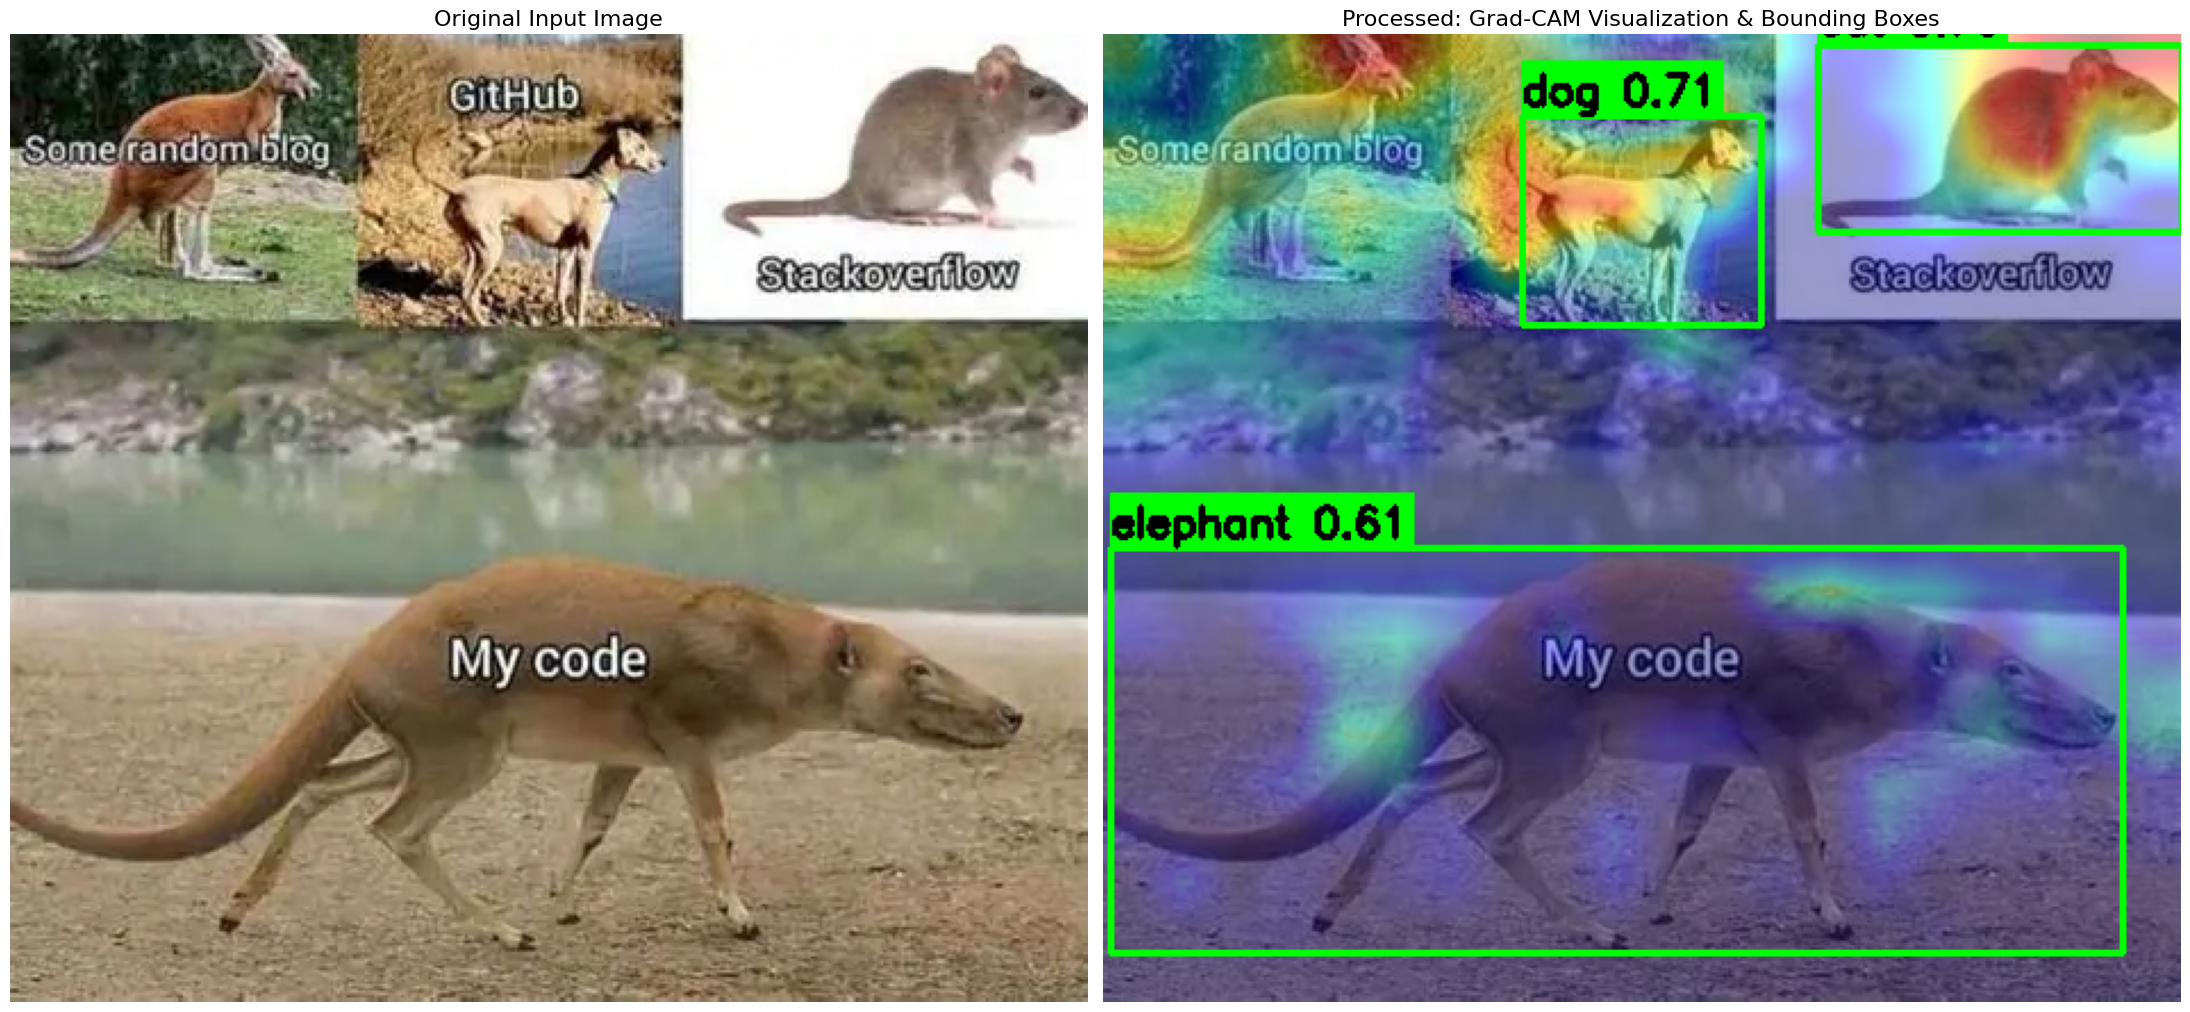

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(22, 11))

# Left Plot: Original Painting
axes[0].imshow(img_rgb)
axes[0].set_title("Original Input Image", fontsize=16)
axes[0].axis('off')

# Right Plot: AI Interpretation (Grad-CAM + Detections)
processed_rgb = cv2.cvtColor(processed_img, cv2.COLOR_BGR2RGB)
axes[1].imshow(processed_rgb)
axes[1].set_title(f"Processed: Grad-CAM Visualization & Bounding Boxes", fontsize=16)
axes[1].axis('off')

plt.tight_layout()
plt.show()